In [32]:
import pandas as pd

In [33]:
df = pd.read_csv('data/NewsAggregatorDataset/newsCorpora.csv', header=None, sep='\t',
                 names=['id', 'title', 'url', 'publisher', 'category', 'story', 'hostname', 'timestamp'])
cols = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
df = df[df['publisher'].isin(cols)]

In [34]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,id,title,url,publisher,category,story,hostname,timestamp
0,33280,Paul Walker's Mom Seeks Guardianship Of Grandd...,http://www.huffingtonpost.com/2014/03/20/paul-...,Huffington Post,e,dt8OZkPGSykQVBMpihvPfWq5hDaLM,www.huffingtonpost.com,1395519611299
1,130445,Ken Loach - Ken Loach and Mike Leigh go head-t...,http://www.contactmusic.com/story/ken-loach-an...,Contactmusic.com,e,dUoA8cGKI_9rzIM_oLwMUIoMlF-SM,www.contactmusic.com,1397774986192
2,194245,Kim Kardashian blogs about racism and raising ...,http://www.dailymail.co.uk/tvshowbiz/article-2...,Daily Mail,e,dKpBJ9x0LO9dFOMvR0aNemATGECSM,www.dailymail.co.uk,1399569379718
3,157373,Kendall Jenner shows support for Kanye West in...,http://www.dailymail.co.uk/tvshowbiz/article-2...,Daily Mail,e,dBu--P82jxm-znMo_j6K5f8UOKeTM,www.dailymail.co.uk,1398342895471
4,99246,Watch 15 Seconds Of Miley Cyrus Covering The B...,http://www.huffingtonpost.com/2014/04/11/miley...,Huffington Post,e,dFA6Pex-ZX47b4M1wbyvVnYiTz13M,www.huffingtonpost.com,1397241791028


(b = business, t = science and technology, e = entertainment, m = health)

In [35]:
df.shape

(13340, 8)

## 51. 特徴量抽出

In [36]:
from sklearn.model_selection import train_test_split

train, rest = train_test_split(df, test_size=0.2, random_state=42, stratify=df['category'])
valid, test = train_test_split(rest, test_size=0.5, random_state=42, stratify=rest['category'])

## 52. 学習, 53. 予測

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# [Choosing the right estimator — scikit\-learn 1\.0\.2 documentation](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
# As cheat sheet, Use LinearSVC or Naive Bayes for Text Classification.

text_nb_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

In [38]:
text_nb_clf.fit(train['title'], train['category'])

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

## 54. 正解率の計測

In [39]:
import numpy as np
np.mean(text_nb_clf.predict(train['title']) == train['category'])


0.8816529235382309

In [40]:
np.mean(text_nb_clf.predict(valid['title']) == valid['category'])

0.8253373313343328

## 55. 混同行列の作成

In [73]:
labels = valid['category'].unique()
labels

array(['b', 'e', 't', 'm'], dtype=object)

In [74]:
from sklearn.metrics import confusion_matrix

confusion_matrix(valid['category'], text_nb_clf.predict(valid['title']), labels=labels)
# 混同行列は y_true に現れた順 https://stackoverflow.com/questions/63649660/how-to-know-scikit-learn-confusion-matrixs-label-order-and-change-it

array([[540,  20,   2,   0],
       [  9, 519,   0,   0],
       [ 83,  47,  23,   0],
       [ 38,  34,   0,  19]])

## 56. 適合率，再現率，F1スコアの計測

In [75]:
from sklearn import  metrics

print(metrics.accuracy_score(valid['category'], text_nb_clf.predict(valid['title'])))
# accuracy: 正解率

print(metrics.classification_report(valid['category'], text_nb_clf.predict(valid['title']), labels=labels))
# precision: 適合率. TP / (TP + FP). FNを許容できる、つまり多少の足切りがOKな場合に使う。
# recall: 再現率. TP / (TP + FN). FPを許容できる、つまり取りこぼしを減らしたいときに使う。
# f1-score: F1スコア. 適合率と再現率の調和平均。つまり、適合率と再現率のどちらか一方が大きいときに、片方犠牲にしてませんか？というのを確かめるために使う。

0.8253373313343328
              precision    recall  f1-score   support

           b       0.81      0.96      0.88       562
           e       0.84      0.98      0.90       528
           t       0.92      0.15      0.26       153
           m       1.00      0.21      0.35        91

    accuracy                           0.83      1334
   macro avg       0.89      0.58      0.60      1334
weighted avg       0.84      0.83      0.78      1334



分析結果を見ると、m(health)とt(science and technology)のf1-scoreが低い。原因はrecallの低さだ。  
つまり、health と science and technologyがbusinessやentertainmentに誤ってカテゴライズされている可能性がある（それらのprecision...合格者の成績優秀率...が低いことも裏付けになる。)  
もしかして、検証データのカテゴリの数を揃えたらうまくいくのか？

## 57. 特徴量の重みの確認

In [68]:
clf: MultinomialNB = text_nb_clf['clf']
# clf.coef_ # deprecated
feature_log_prob_ = clf.feature_log_prob_
feature_log_prob_

# それぞれのfeatureにおける、それぞれのcategoryについての事前確率を求める。元々の値は 0.XXXX... だが、自然対数に変換されている。

array([[ -9.87781835,  -9.79759664,  -9.85390126, ..., -10.17534004,
        -10.17534004, -10.17534004],
       [-10.14357132, -10.14357132, -10.14357132, ...,  -9.78364884,
         -9.813382  ,  -9.79818251],
       [ -9.61419708,  -9.61419708,  -9.61419708, ...,  -9.61419708,
         -9.61419708,  -9.61419708],
       [ -9.70613006,  -9.70613006,  -9.70613006, ...,  -9.70613006,
         -9.70613006,  -9.70613006]])

In [48]:
clf.coef_.shape

/Users/hiroga/.ghq/github.com/xhiroga/til/computer-science/nlp/nlp100/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


(4, 12763)

In [65]:
type(feature_log_prob_)

numpy.ndarray

In [76]:
clf.classes_

array(['b', 'e', 'm', 't'], dtype='<U1')

In [67]:
feature_names =  text_nb_clf[:-1].get_feature_names_out()
feature_names

array(['00', '08', '09', ..., 'œlousyâ', 'œpiece', 'œwaist'], dtype=object)

In [79]:
features_df = pd.DataFrame(feature_log_prob_, columns=feature_names, index=clf.classes_).head()
features_df

,00,08,09,10,100,1000,100000,100k,100th,101,...,zombie,zombies,zone,zoosk,zuckerberg,zynga,zâ,œlousyâ,œpiece,œwaist
b,-9.877818,-9.797597,-9.853901,-7.625679,-8.047377,-9.435618,-9.592183,-10.175340,-10.175340,-9.549174,...,-10.175340,-9.804108,-7.313599,-9.805473,-9.874870,-9.418763,-10.175340,-10.175340,-10.175340,-10.175340
e,-10.143571,-10.143571,-10.143571,-8.351772,-8.790078,-9.855233,-10.143571,-9.822957,-9.820330,-10.143571,...,-10.143571,-10.143571,-10.143571,-10.143571,-10.143571,-10.143571,-9.789245,-9.783649,-9.813382,-9.798183
m,-9.614197,-9.614197,-9.614197,-9.127658,-8.669316,-9.111801,-9.614197,-9.614197,-9.614197,-9.614197,...,-9.614197,-9.614197,-9.386251,-9.614197,-9.614197,-9.614197,-9.614197,-9.614197,-9.614197,-9.614197
t,-9.706130,-9.706130,-9.706130,-8.675680,-9.460100,-9.404062,-9.378791,-9.706130,-9.706130,-9.706130,...,-9.173786,-9.706130,-9.481236,-9.706130,-8.780237,-9.706130,-9.706130,-9.706130,-9.706130,-9.706130


<AxesSubplot:>

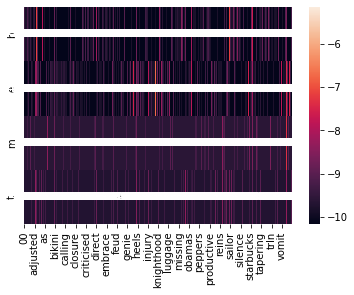

In [80]:
import seaborn as sns
sns.heatmap(features_df, annot=True, fmt='.2f')
# 実行に2分かかる。 

## 58. 正則化パラメータの変更 & 59. ハイパーパラメータの探索

In [81]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3),
}


In [83]:
gs_clf = GridSearchCV(text_nb_clf, parameters, cv=5, n_jobs=-1) # n_jobs=-1 means all CPUs

In [84]:
gs_clf = gs_clf.fit(train['title'], train['category'])

In [85]:
gs_clf.best_score_

0.9151989973859165